In [154]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

SPS_PER_HOUR = 2
MINS_PER_SP = int(60 / SPS_PER_HOUR)
MAX_POWER = 50
MAX_VOL_PER_SP = MAX_POWER / SPS_PER_HOUR  # MWh
RAMP_RATE_MAGNITUDE = 4  # MWh per minute
TOTAL_SPS = 12

In [155]:
volumes_mwh = np.random.randint(low=-MAX_VOL_PER_SP, high=MAX_VOL_PER_SP, size=TOTAL_SPS)
baseline_starts = [(volume_mwh * SPS_PER_HOUR) / 2 for volume_mwh in volumes_mwh]
baseline_ends = [(volume_mwh * SPS_PER_HOUR) / 2 for volume_mwh in volumes_mwh[1:]]
baseline_ends.append((volumes_mwh[-1] * SPS_PER_HOUR) / 2)

In [156]:
solution_sets = []

for i in range(len(volumes_mwh)):
    baseline_start = baseline_starts[i]
    baseline_end = baseline_ends[i]
    RAMP_RATE = RAMP_RATE_MAGNITUDE
    if baseline_end < baseline_start:
        RAMP_RATE = -RAMP_RATE

    Bx, By, Cx = sym.symbols("Bx,By,Cx")
    eq1 = sym.Eq((By - baseline_start) / Bx, RAMP_RATE)
    eq2 = sym.Eq((baseline_end - By) / (30 - Cx), -RAMP_RATE)
    eq3 = sym.Eq(
        (
            Bx * (baseline_start + By) / 2
            + By * (Cx - Bx)
            + (30 - Cx) * (By + baseline_end) / 2
        )
        / 60,
        volumes_mwh[i],
    )
    solution_set = sym.solve([eq1, eq2, eq3], (Bx, By, Cx))
    solution_sets.append(solution_set)

In [157]:
baseline_points = np.zeros((TOTAL_SPS, 4, 2))
for i in range(len(baseline_points)):
    baseline_points[i, :3, 0] = i * MINS_PER_SP
    baseline_points[i, 3, 0] = (i + 1) * MINS_PER_SP

for i in range(len(solution_sets)):
    for solution in solution_sets[i]:
        if all(map(lambda sympy_num: sympy_num.is_real, solution)):
            Bx, By, Cx = solution
            if Bx > 0 and Cx > Bx and Cx <= MINS_PER_SP:
                print(f"valid solution found: {i, solution}")
                baseline_points[i][0][0] = i * MINS_PER_SP     # Ax
                baseline_points[i][0][1] = baseline_starts[i]  # Ay
                baseline_points[i][1][0] = Bx + i * MINS_PER_SP
                baseline_points[i][1][1] = By
                baseline_points[i][2][0] = Cx + i * MINS_PER_SP
                baseline_points[i][2][1] = By  # Cy = By
                baseline_points[i][3][0] = (i + 1) * MINS_PER_SP
                baseline_points[i][3][1] = baseline_ends[i]

baseline_x_coords = baseline_points[:,:,0].flatten()
baseline_y_coords = baseline_points[:,:,1].flatten()


valid solution found: (5, (2.90419914629121, 22.6167965851648, 29.0958008537088))
valid solution found: (7, (2.08397437414728, -16.3358974965891, 29.1660256258527))
valid solution found: (9, (3.00510310374154, 23.0204124149662, 27.4948968962585))
valid solution found: (10, (3.66924271381416, 27.6769708552566, 26.5807572861858))
valid solution found: (11, (4.04554884989668, 30.1821953995867, 25.9544511501033))


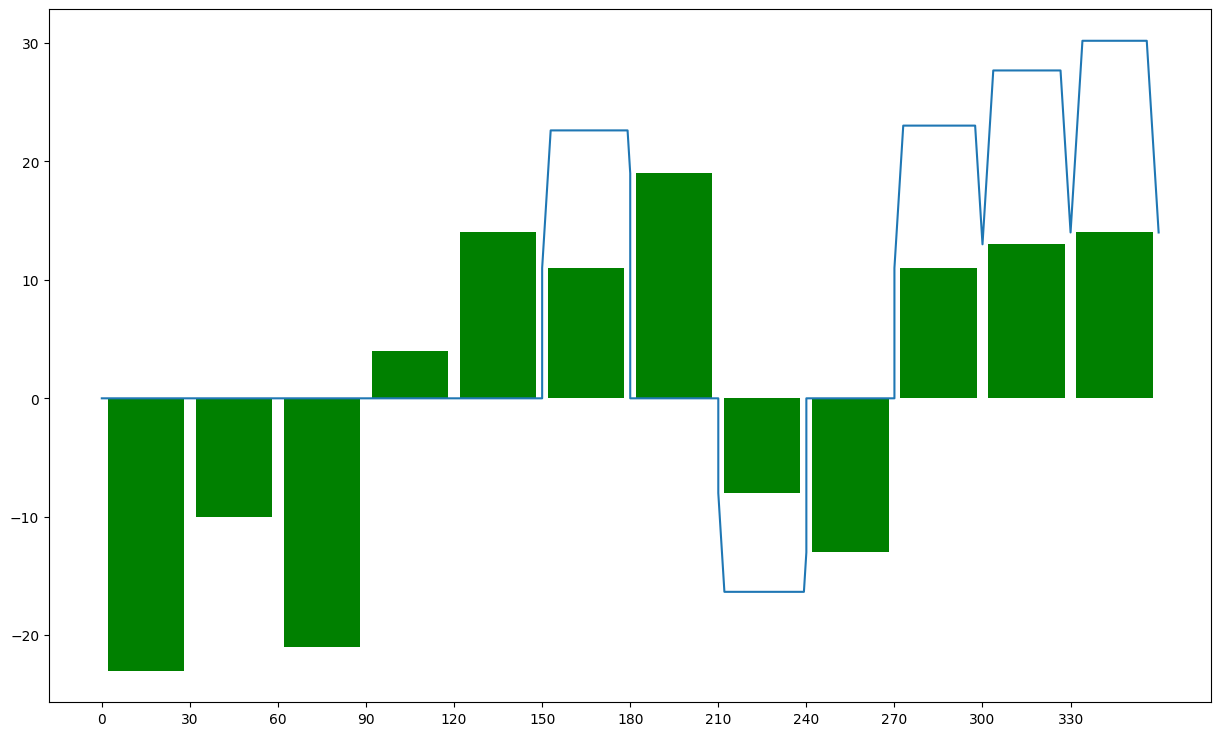

In [158]:
plt.figure(figsize=(15, 9))
plt.xticks(range(0, MINS_PER_SP * TOTAL_SPS, MINS_PER_SP))
indices = (np.arange(len(volumes_mwh)) * 30) + 2
plt.bar(indices, volumes_mwh, width=26, align='edge', color='green')
plt.plot(baseline_x_coords, baseline_y_coords)
plt.show()